In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pylab as plt
from torchvision.datasets import MNIST, FashionMNIST, CIFAR100
from torchvision import transforms
from torch.utils.data import Subset

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


A central goal for us is to replace policies in various systems (compilers, operating systems, schedulers etc.) by statistical models that can adapt. In order to do so, our models need to output what values we should set various parameters to. These parameters are almost always integers in some range $[0, N_{\text{max}}-1]$.

If the model is a neural network, we can treat this as a classification model with $N_{\text{max}}$ classes. While this is a reasonable approach, we would like to explore alternate representations of the output and their effects on the model's ability to learn.

In this notebook, we use MNIST as a dataset. This is the standard, small dataset consisting of hand-written digits with 10 classes (digits $0,\ldots,9$). While this is no longer a challenging dataset for neural networks, it is very useful for experiments like the ones here.

The three representations we try are:

1. Classification with a softmax layer on $N_{\text{max}}$ classes. This is the classic treatment with a cross-entropy loss.

2. Treating the output class as a bit-vector. As motivation consider the parameter "asan-instrumentation-with-call-threshold" for gcc (v9.2.1). This parameter takes values from 0 to 2,147,483,647. An output with ~2 billion classes will result in sparse probabilities as well as a large memory footprint. 

Computers represent such integers as bit-vectors of length $\log_2(N_{\text{max}})$ (31 bits - probably a 4-byte int). We will represent the labels as these bit-vectors too and treat the output layer as $\log_2(N_{\text{max}})$ sigmoid nodes with a cross-entropy loss for each bit.

We can guess some of the things that can go wrong here. Consider the label, $5 = (101)_2$.



In [93]:
def filter_dataset(dataset, limit):
    dataset.targets = np.array(dataset.targets)
    
    idx = np.where(dataset.targets <= limit)[0]
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]
    
    return dataset

def plot_samples(dataset, N_samples=3):
    for idx in np.random.choice(dataset.data.shape[0], N_samples):
        plt.figure()
        plt.imshow(dataset.data[idx])
        print(dataset.targets[idx], dataset.classes[dataset.targets[idx]])
        
        
def create_dataloader(dataset, batch_size, num_workers=8):
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=num_workers,
                                             pin_memory=True)
    
    return dataloader

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)
        
def train_network(net, N_epochs, train_dataloader, criterion, optimizer, preprocess_target=None):
    net.train()
    net.to(device)

    for epoch in range(N_epochs):
        loss_list = []
        for idx, (data_example, data_target) in enumerate(train_dataloader):
            data_example = data_example.to(device)
            data_target = data_target.to(device)

            if preprocess_target is not None:
                data_target = preprocess_target(data_target)
                #data_target = convert_to_binary(data_target)
                
            pred = net(data_example)

            loss = criterion(pred, data_target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        if epoch % 5 == 0:        
            print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')    
        
    return net, loss_list

def compute_accuracy(dataloader, net, process_pred=lambda x: x.argmax(dim=1).float()):
    net.eval()
    pred, targets = torch.tensor([]), torch.tensor([])

    with torch.no_grad(): #context manager for inference since we don't need the memory footprint of gradients
        for idx, (data_example, data_target) in enumerate(dataloader):
            data_example = data_example.to(device)

            #make predictions
            label_pred = process_pred(net(data_example))
                
            #concat and store both predictions and targets
            label_pred = label_pred.to('cpu')
            pred = torch.cat((pred, label_pred))
            targets = torch.cat((targets, data_target.float()))

    assert(pred.shape == targets.shape)
    accuracy = torch.sum(pred == targets).item() / pred.shape[0]
    print(f'Accuracy = {accuracy:.4f}')

## Experiment 1: Softmax (Standard)

### MNIST:

In [87]:
DOWNLOAD_PATH = "/home/sanjay/BrnoMLWorkshop2019/BrnoTeaching2019/data/MNIST"

In [88]:
#Get raw data
mnist_train = MNIST(DOWNLOAD_PATH, 
                    train=True, 
                    download=True,
                    transform = transforms.Compose([transforms.ToTensor()]))

mnist_test = MNIST(DOWNLOAD_PATH, 
                   train=False, 
                   download=True,
                   transform = transforms.Compose([transforms.ToTensor()]))

In [89]:
#Filter to keep some power of 2 number of classes
mnist_train = filter_dataset(mnist_train, 7)
mnist_test = filter_dataset(mnist_test, 7)

7 7 - seven
3 3 - three
2 2 - two


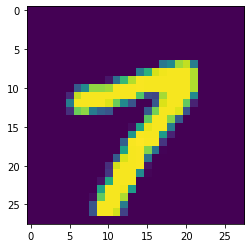

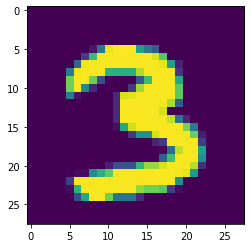

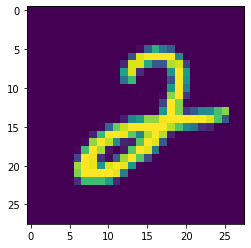

In [90]:
plot_samples(mnist_train)

In [40]:
#dimensions of data
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

print(mnist_test.data.shape)
print(mnist_test.targets.shape)

torch.Size([48200, 28, 28])
(48200,)
torch.Size([8017, 28, 28])
(8017,)


In [45]:
#create dataloaders for barches
mnist_train_dataloader = create_dataloader(mnist_train, num_workers=8, batch_size=64)
mnist_test_dataloader = create_dataloader(mnist_test, num_workers=8, batch_size=64)

In [46]:
#one batch
idx, (data_example, target_example) = next(enumerate(mnist_train_dataloader))
print(data_example.shape)
print(target_example)

print(f"Flattening: {Flatten()(data_example).shape}")

torch.Size([64, 1, 28, 28])
tensor([1, 7, 2, 3, 3, 4, 6, 1, 0, 1, 1, 5, 0, 1, 6, 6, 0, 3, 2, 3, 1, 6, 4, 1,
        1, 2, 4, 5, 7, 2, 3, 3, 2, 1, 1, 4, 3, 1, 2, 2, 0, 4, 6, 0, 6, 4, 4, 4,
        1, 7, 4, 7, 2, 7, 5, 2, 1, 7, 3, 5, 2, 5, 7, 4])
Flattening: torch.Size([64, 784])


In [47]:
flattened_dimensions = np.prod(mnist_train.data[0].shape)
n_unique_classes = len(np.unique(mnist_train.targets))

net = nn.Sequential(Flatten(), 
                    nn.Linear(flattened_dimensions, 100),
                    nn.ReLU(),
                    nn.Linear(100, n_unique_classes),
                   )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

print(f"Flattened Dimensions: {flattened_dimensions}")
print(f'N Unique Classes: {n_unique_classes}')
print(net)

Flattened Dimensions: 784
N Unique Classes: 8
Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=8, bias=True)
)


In [48]:
N_epochs = 20
net, loss_list = train_network(net, 
                               N_epochs, 
                               mnist_train_dataloader, 
                               criterion, 
                               optimizer)

Epoch = 0 Loss = 0.1596080994317481
Epoch = 5 Loss = 0.05248247175162475
Epoch = 10 Loss = 0.04463418360891572
Epoch = 15 Loss = 0.03230937896790452


In [49]:
print("Train")
compute_accuracy(mnist_train_dataloader, net)

print("Test")
compute_accuracy(mnist_test_dataloader, net)

Train
Accuracy = 0.9940
Test
Accuracy = 0.9793


#### Save Model

In [94]:
#torch.save(net.state_dict(), './softmax_mnist_epoch20_loss0.032.pkl')

flattened_dimensions = np.prod(mnist_train.data[0].shape)
n_unique_classes = len(np.unique(mnist_train.targets))

net2 = nn.Sequential(Flatten(), 
                    nn.Linear(flattened_dimensions, 100),
                    nn.ReLU(),
                    nn.Linear(100, n_unique_classes),
                   )
net2.load_state_dict(torch.load('./softmax_mnist_epoch20_loss0.032.pkl'))
net2.to(device)

print("Train")
compute_accuracy(mnist_train_dataloader, net2)

print("Test")
compute_accuracy(mnist_test_dataloader, net2)

Train
Accuracy = 0.9940
Test
Accuracy = 0.9793


### FashionMNIST

In [5]:
DOWNLOAD_PATH = "/home/sanjay/BrnoMLWorkshop2019/BrnoTeaching2019/data/MNIST"

In [6]:
fmnist_train = FashionMNIST(DOWNLOAD_PATH, 
                            train=True, 
                            download=True,
                            transform = transforms.Compose([transforms.ToTensor()]))

fmnist_test = FashionMNIST(DOWNLOAD_PATH, 
                           train=False, 
                           download=True,
                           transform = transforms.Compose([transforms.ToTensor()]))

In [7]:
fmnist_train = filter_dataset(fmnist_train, 7)
fmnist_test = filter_dataset(fmnist_test, 7)

5 Sandal
1 Trouser
4 Coat


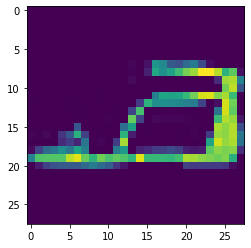

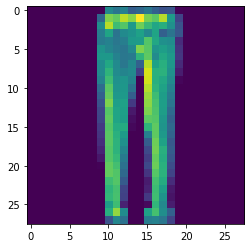

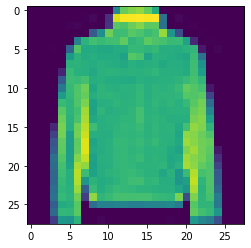

In [9]:
plot_samples(fmnist_train, 3)

In [10]:
print(fmnist_train.data.shape)
print(fmnist_train.targets.shape)

print(fmnist_test.data.shape)
print(fmnist_test.targets.shape)

torch.Size([48000, 28, 28])
(48000,)
torch.Size([8000, 28, 28])
(8000,)


In [11]:
fmnist_train_dataloader = create_dataloader(fmnist_train, num_workers=8, batch_size=128)
fmnist_test_dataloader = create_dataloader(fmnist_test, num_workers=8, batch_size=128)

In [12]:
#one batch
idx, (data_example, target_example) = next(enumerate(fmnist_train_dataloader))
print(data_example.shape)
print(target_example)

print(f"Flattening: {Flatten()(data_example).shape}")

torch.Size([128, 1, 28, 28])
tensor([0, 1, 2, 4, 2, 6, 3, 1, 1, 3, 2, 0, 4, 2, 0, 5, 7, 0, 7, 4, 5, 2, 4, 1,
        1, 5, 4, 4, 1, 6, 5, 2, 4, 2, 0, 0, 3, 4, 7, 4, 2, 5, 5, 1, 1, 2, 6, 0,
        7, 4, 5, 6, 3, 7, 7, 5, 6, 3, 1, 2, 5, 7, 7, 5, 5, 5, 0, 7, 1, 6, 0, 4,
        7, 0, 6, 3, 3, 1, 6, 2, 5, 1, 0, 5, 7, 1, 1, 2, 7, 3, 6, 4, 3, 6, 6, 6,
        0, 5, 0, 6, 4, 3, 6, 2, 2, 4, 3, 6, 5, 2, 2, 0, 6, 7, 1, 3, 0, 1, 6, 4,
        7, 1, 0, 2, 3, 0, 0, 3])
Flattening: torch.Size([128, 784])


In [19]:
flattened_dimensions = np.prod(fmnist_train.data[0].shape)
n_unique_classes = len(np.unique(fmnist_train.targets))

net = nn.Sequential(nn.Conv2d(1, 96, (3,3)),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3), stride=2),                    
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),

                    nn.Conv2d(192, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(192, 192, (3,3), stride=2),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    Flatten(),
                    nn.Linear(1728, n_unique_classes),
                   )

#net = nn.Sequential(Flatten(), 
#                    nn.Linear(flattened_dimensions, 100),
#                    nn.ReLU(),
#                    nn.Linear(100, n_unique_classes),
#                   )

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

print(f"Flattened Dimensions: {flattened_dimensions}")
print(f'N Unique Classes: {n_unique_classes}')
print(net)

Flattened Dimensions: 784
N Unique Classes: 8
Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten()
  (19): Linear(in_features=1728, out_features=8, bias=True)
)


In [21]:
N_epochs = 1000 #2000
net, loss_list = train_network(net, 
                               N_epochs, 
                               fmnist_train_dataloader, 
                               criterion, 
                               optimizer)

Epoch = 0 Loss = 0.7384399970372518
Epoch = 5 Loss = 0.46947388887405395
Epoch = 10 Loss = 0.3913606618642807
Epoch = 15 Loss = 0.348474599758784
Epoch = 20 Loss = 0.31743119140466053
Epoch = 25 Loss = 0.2937150587240855
Epoch = 30 Loss = 0.2756553853750229
Epoch = 35 Loss = 0.2622337094942729
Epoch = 40 Loss = 0.2505190439224243
Epoch = 45 Loss = 0.23806978489955266
Epoch = 50 Loss = 0.2308765326142311
Epoch = 55 Loss = 0.2238030779361725
Epoch = 60 Loss = 0.21411466697851816
Epoch = 65 Loss = 0.20835373562574386
Epoch = 70 Loss = 0.19868405936161676
Epoch = 75 Loss = 0.19371261819203694
Epoch = 80 Loss = 0.18769448337952296
Epoch = 85 Loss = 0.18097124403715134
Epoch = 90 Loss = 0.17794790190458298
Epoch = 95 Loss = 0.17290807966391245
Epoch = 100 Loss = 0.16849607997139296
Epoch = 105 Loss = 0.1664237975378831
Epoch = 110 Loss = 0.1607591983874639
Epoch = 115 Loss = 0.15808990199367207
Epoch = 120 Loss = 0.15156330054004988
Epoch = 125 Loss = 0.15054064713915188
Epoch = 130 Loss = 0

In [25]:
print("Train")
compute_accuracy(fmnist_train_dataloader, net)

print("Test")
compute_accuracy(fmnist_test_dataloader, net)

Train
Accuracy = 1.0000
Test
Accuracy = 0.9266


#### Save Model

In [41]:
#torch.save(net.state_dict(), './softmax_fmnist_epoch1000_loss0.056.pkl')

In [95]:
flattened_dimensions = np.prod(fmnist_train.data[0].shape)
n_unique_classes = len(np.unique(fmnist_train.targets))

net2 = nn.Sequential(nn.Conv2d(1, 96, (3,3)),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3), stride=2),                    
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),

                    nn.Conv2d(192, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(192, 192, (3,3), stride=2),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    Flatten(),
                    nn.Linear(1728, n_unique_classes),
                   )
net2.load_state_dict(torch.load('./softmax_fmnist_epoch1000_loss0.056.pkl'))
net2.to(device)

Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten()
  (19): Linear(in_features=1728, out_features=8, bias=True)
)

In [96]:
print("Train")
compute_accuracy(fmnist_train_dataloader, net2)

print("Test")
compute_accuracy(fmnist_test_dataloader, net2)

Train
Accuracy = 1.0000
Test
Accuracy = 0.9266


## Experiment 2:  Bit vectors

### MNIST

In [97]:
DOWNLOAD_PATH = "/home/sanjay/BrnoMLWorkshop2019/BrnoTeaching2019/data/MNIST"

In [98]:
#Get raw data
mnist_train = MNIST(DOWNLOAD_PATH, 
                    train=True, 
                    download=True,
                    transform = transforms.Compose([transforms.ToTensor()]))

mnist_test = MNIST(DOWNLOAD_PATH, 
                   train=False, 
                   download=True,
                   transform = transforms.Compose([transforms.ToTensor()]))

In [99]:
#Filter to keep some power of 2 number of classes
mnist_train = filter_dataset(mnist_train, 7)
mnist_test = filter_dataset(mnist_test, 7)

1 1 - one
7 7 - seven
7 7 - seven


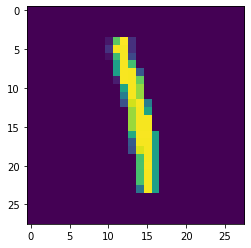

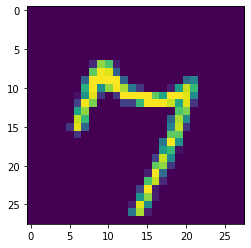

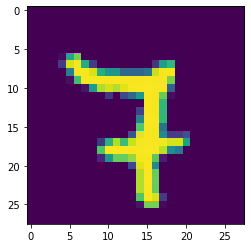

In [100]:
plot_samples(mnist_train)

In [101]:
#dimensions of data
print(mnist_train.data.shape)
print(mnist_train.targets.shape)

print(mnist_test.data.shape)
print(mnist_test.targets.shape)

torch.Size([48200, 28, 28])
(48200,)
torch.Size([8017, 28, 28])
(8017,)


In [102]:
#create dataloaders for barches
mnist_train_dataloader = create_dataloader(mnist_train, num_workers=8, batch_size=64)
mnist_test_dataloader = create_dataloader(mnist_test, num_workers=8, batch_size=64)

In [103]:
#one batch
idx, (data_example, target_example) = next(enumerate(mnist_train_dataloader))
print(data_example.shape)
print(target_example)
print(f"Flattening: {Flatten()(data_example).shape}")

torch.Size([64, 1, 28, 28])
tensor([2, 7, 2, 0, 7, 6, 1, 1, 3, 1, 6, 7, 2, 2, 3, 7, 6, 3, 3, 0, 2, 1, 1, 3,
        0, 0, 4, 2, 4, 0, 7, 1, 2, 0, 0, 0, 2, 2, 6, 1, 5, 3, 3, 7, 7, 1, 7, 6,
        5, 4, 3, 4, 2, 3, 1, 0, 7, 4, 0, 2, 4, 3, 0, 1])
Flattening: torch.Size([64, 784])


In [104]:
flattened_dimensions = np.prod(mnist_train.data[0].shape)
n_unique_classes = int(np.log2(len(np.unique(mnist_train.targets)))) #CHANGE

net = nn.Sequential(Flatten(), 
                    nn.Linear(flattened_dimensions, 100),
                    nn.ReLU(),
                    nn.Linear(100, n_unique_classes),
                   )

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

print(f"Flattened Dimensions: {flattened_dimensions}")
print(f'N Unique Classes: {n_unique_classes}')
print(f'Loss Criterion = {criterion}')
print(net)

Flattened Dimensions: 784
N Unique Classes: 3
Loss Criterion = BCEWithLogitsLoss()
Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=3, bias=True)
)


In [105]:
#some checks
net.to(device)

idx, (data_example, data_target) = next(enumerate(mnist_train_dataloader))
data_example = data_example.to(device)
data_target = data_target.to(device)

pred = net(data_example[0:5])
print(pred)

tensor([[ 0.1662, -0.0190,  0.2225],
        [ 0.0940,  0.0043,  0.0564],
        [ 0.2298, -0.0191,  0.0947],
        [ 0.1138, -0.0195,  0.0964],
        [ 0.2533, -0.1064,  0.0684]], device='cuda:0', grad_fn=<AddmmBackward>)


In [106]:
def convert_to_binary(labels):
    '''Convert base 10 int to binary representation
    '''

    binrep = []
    for d in labels:
        rep = []
        for i in np.binary_repr(d, width=3):
            rep.append(int(i))
        binrep.append(rep)
    binrep = torch.Tensor(binrep).float().to(device)
    
    return binrep

def convert_to_decimal(binrep):
    '''Convert binary representation to base 10 int
    '''
    labels = []
    for d in binrep:
        labels.append(int("".join([str(int(i)) for i in d]), base=2))
    return labels

In [107]:
#some checks
binrep = convert_to_binary(data_target[0:5])
print(data_target[0:5])
print(binrep)

print(data_target[0:5])
print(convert_to_decimal(binrep.to('cpu')))

tensor([2, 4, 0, 5, 6], device='cuda:0')
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [1., 0., 1.],
        [1., 1., 0.]], device='cuda:0')
tensor([2, 4, 0, 5, 6], device='cuda:0')
[2, 4, 0, 5, 6]


In [108]:
t = nn.Sigmoid()(pred)

In [109]:
(t > 0.5).int()

tensor([[1, 0, 1],
        [1, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]], device='cuda:0', dtype=torch.int32)

In [110]:
N_epochs = 20
net, loss_list = train_network(net, 
                               N_epochs, 
                               mnist_train_dataloader, 
                               criterion, 
                               optimizer,
                               preprocess_target=convert_to_binary)

Epoch = 0 Loss = 0.08529392652094997
Epoch = 5 Loss = 0.020167405293744892
Epoch = 10 Loss = 0.013180100353031894
Epoch = 15 Loss = 0.010419923057955414


In [112]:
sig = nn.Sigmoid()
process_pred = lambda x: torch.Tensor(convert_to_decimal((sig(x) >= 0.5).int()))

print("Train")
compute_accuracy(mnist_train_dataloader, net, process_pred=process_pred)

print("Test")
compute_accuracy(mnist_test_dataloader, net, process_pred=process_pred)

Train
Accuracy = 0.9913
Test
Accuracy = 0.9721


### Fashion MNIST

In [113]:
DOWNLOAD_PATH = "/home/sanjay/BrnoMLWorkshop2019/BrnoTeaching2019/data/MNIST"

In [114]:
fmnist_train = FashionMNIST(DOWNLOAD_PATH, 
                            train=True, 
                            download=True,
                            transform = transforms.Compose([transforms.ToTensor()]))

fmnist_test = FashionMNIST(DOWNLOAD_PATH, 
                           train=False, 
                           download=True,
                           transform = transforms.Compose([transforms.ToTensor()]))

In [115]:
fmnist_train = filter_dataset(fmnist_train, 7)
fmnist_test = filter_dataset(fmnist_test, 7)

7 Sneaker
2 Pullover
5 Sandal


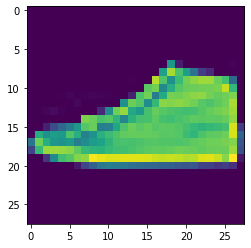

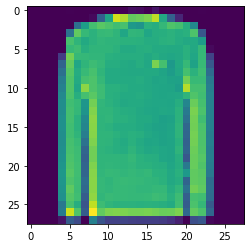

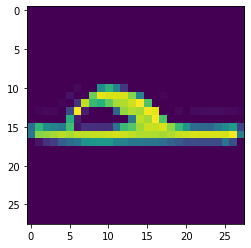

In [116]:
plot_samples(fmnist_train, 3)

In [117]:
print(fmnist_train.data.shape)
print(fmnist_train.targets.shape)

print(fmnist_test.data.shape)
print(fmnist_test.targets.shape)

torch.Size([48000, 28, 28])
(48000,)
torch.Size([8000, 28, 28])
(8000,)


In [118]:
fmnist_train_dataloader = create_dataloader(fmnist_train, num_workers=8, batch_size=128)
fmnist_test_dataloader = create_dataloader(fmnist_test, num_workers=8, batch_size=128)

In [120]:
#one batch
idx, (data_example, target_example) = next(enumerate(fmnist_train_dataloader))
print(data_example.shape)
print(target_example)
print(f"Flattening: {Flatten()(data_example).shape}")

torch.Size([128, 1, 28, 28])
tensor([4, 6, 3, 4, 5, 4, 3, 4, 3, 3, 7, 0, 1, 7, 6, 2, 0, 0, 6, 6, 7, 6, 4, 4,
        0, 6, 0, 4, 0, 7, 7, 5, 5, 5, 0, 7, 2, 2, 2, 5, 7, 5, 1, 2, 5, 0, 6, 4,
        0, 7, 2, 6, 1, 6, 4, 2, 1, 2, 3, 3, 3, 7, 2, 7, 7, 4, 7, 4, 3, 7, 0, 6,
        6, 0, 5, 6, 7, 4, 7, 7, 7, 5, 1, 6, 7, 4, 1, 1, 5, 0, 4, 7, 2, 7, 0, 6,
        4, 3, 4, 5, 2, 7, 6, 2, 2, 7, 3, 7, 6, 3, 7, 2, 1, 4, 4, 1, 4, 1, 0, 2,
        5, 4, 5, 2, 3, 7, 7, 2])
Flattening: torch.Size([128, 784])


In [123]:
flattened_dimensions = np.prod(fmnist_train.data[0].shape)
n_unique_classes = int(np.log2(len(np.unique(fmnist_train.targets))))

net = nn.Sequential(nn.Conv2d(1, 96, (3,3)),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3), stride=2),                    
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),

                    nn.Conv2d(192, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(192, 192, (3,3), stride=2),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    Flatten(),
                    nn.Linear(1728, n_unique_classes),
                   )

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

print(f"Flattened Dimensions: {flattened_dimensions}")
print(f'N Unique Classes: {n_unique_classes}')
print(f'Loss Criterion = {criterion}')
print(net)

Flattened Dimensions: 784
N Unique Classes: 3
Loss Criterion = BCEWithLogitsLoss()
Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten()
  (19): Linear(in_features=1728, out_features=3, bias=True)
)


In [124]:
N_epochs = 700 #1000 #2000
net, loss_list = train_network(net, 
                               N_epochs, 
                               fmnist_train_dataloader, 
                               criterion, 
                               optimizer,
                               preprocess_target=convert_to_binary)

Epoch = 0 Loss = 0.4342790733973185
Epoch = 5 Loss = 0.23216146636009216
Epoch = 10 Loss = 0.2005605888366699
Epoch = 15 Loss = 0.18152239221334457
Epoch = 20 Loss = 0.16466756931940715
Epoch = 25 Loss = 0.15245192960898082
Epoch = 30 Loss = 0.1435787995457649
Epoch = 35 Loss = 0.13619600226481757
Epoch = 40 Loss = 0.13061896602312723
Epoch = 45 Loss = 0.12468153727054596
Epoch = 50 Loss = 0.12006285323699316
Epoch = 55 Loss = 0.1153759748339653
Epoch = 60 Loss = 0.11188350332776706
Epoch = 65 Loss = 0.10907868774731953
Epoch = 70 Loss = 0.10609426784515381
Epoch = 75 Loss = 0.10274729677041372
Epoch = 80 Loss = 0.10044899447758993
Epoch = 85 Loss = 0.0987532576918602
Epoch = 90 Loss = 0.09654146747787794
Epoch = 95 Loss = 0.09377914798259736
Epoch = 100 Loss = 0.09084911330540975
Epoch = 105 Loss = 0.08977590793371201
Epoch = 110 Loss = 0.08757436085740725
Epoch = 115 Loss = 0.08656138890981674
Epoch = 120 Loss = 0.08349677514036496
Epoch = 125 Loss = 0.08402074648439885
Epoch = 130 L

In [125]:
sig = nn.Sigmoid()
process_pred = lambda x: torch.Tensor(convert_to_decimal((sig(x) >= 0.5).int()))

print("Train")
compute_accuracy(fmnist_train_dataloader, net, process_pred=process_pred)

print("Test")
compute_accuracy(fmnist_test_dataloader, net, process_pred=process_pred)

Train
Accuracy = 0.9996
Test
Accuracy = 0.9119


#### Save Model

In [126]:
#torch.save(net.state_dict(), './bitrep_fmnist_epoch1000_loss0.036.pkl')

In [129]:
flattened_dimensions = np.prod(fmnist_train.data[0].shape)
n_unique_classes = int(np.log2(len(np.unique(fmnist_train.targets))))

net2 = nn.Sequential(nn.Conv2d(1, 96, (3,3)),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 96, (3,3), stride=2),                    
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(96, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),

                    nn.Conv2d(192, 192, (3,3)),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    nn.Conv2d(192, 192, (3,3), stride=2),
                    nn.ReLU(),      
                    nn.Dropout(0.5),
                    
                    Flatten(),
                    nn.Linear(1728, n_unique_classes),
                   )
net2.load_state_dict(torch.load('./bitrep_fmnist_epoch1000_loss0.036.pkl'))
net2.to(device)

Sequential(
  (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1))
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2))
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Flatten()
  (19): Linear(in_features=1728, out_features=3, bias=True)
)

In [130]:
sig = nn.Sigmoid()
process_pred = lambda x: torch.Tensor(convert_to_decimal((sig(x) >= 0.5).int()))

print("Train")
compute_accuracy(fmnist_train_dataloader, net2, process_pred=process_pred)

print("Test")
compute_accuracy(fmnist_test_dataloader, net2, process_pred=process_pred)

Train
Accuracy = 0.9996
Test
Accuracy = 0.9119


## Experiment 3: Rounding

Predict Sigmoid -> scale -> round

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, inp):
        return inp.flatten(start_dim=1, end_dim=-1)
    
net = nn.Sequential(Flatten(), 
                    nn.Linear(784, 100),
                    nn.ReLU(),
                    nn.Linear(100, 1), 
                    nn.ReLU(), #1 scaled class number
                   )

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
net.train()
net.to(device)

N_EPOCHS = 20
MAX_CLASS = 8
for epoch in range(N_EPOCHS):
    loss_list = []
    for idx, (data_example, data_target) in enumerate(train_dataloader):
        data_example = data_example.to(device)
        data_target = data_target.to(device).float()
        
        pred = net(data_example).squeeze(1) #[0,1]
        
        pred = torch.round(pred * MAX_CLASS)
        
        loss = criterion(pred, data_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        
    if epoch % 5 == 0:        
        print(f'Epoch = {epoch} Loss = {np.mean(loss_list)}')

In [ ]:
data_target.shape

In [ ]:
pred.squeeze(1)

In [ ]:
torch.round(torch.tensor([0.3, 1.2, 1.7]))

In [ ]:
net = net.to(device)

In [ ]:
data_target